In [1]:
# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [0]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
train_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv').set_index('id')
test_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test.csv').set_index('id')

### 분석 방법

1. Y00 - Y17 4300개의 데이터로 각 feature 430개의 값을 예측 
    - Y18 값과 유사한 feature 찾기
    - Y06,Y09,Y12,Y16이 Y18과의 mse값이 낮고, 상관도가 높다.

2. Y06,Y09,Y12,Y16의 조합으로 진짜 Y18을 예측
    - mse가 가장 낮은 조합을 사용

3.  Y_train 값 설정
  - 2번의 조합 + 기존의 Y18로 나머지 test 예측
  - 2번의 조합에서 각각의 Y로 80일 예측 후 평균

4. feature 공학

In [0]:
def predict_test(X_train, y_train, X_test):

  lgb_train = lgb.Dataset(X_train, label=y_train)

  lgb_param = {
      "objective":"regression",
      "metrics":"mae",
      "learning_rate":0.05
  }

  print("cv start")
  cv_result = lgb.cv(
      lgb_param,
      lgb_train,
      num_boost_round=99999,
      nfold=5,
      early_stopping_rounds=100,
      stratified=False,
      verbose_eval=10 
  )

  print("train start")
  lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result["l1-mean"])
  )

  pred = lgb_model.predict(X_test)

  return pred

In [0]:
X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]
Y_train = train_dt.loc[:4319, ['Y09', 'Y12']].mean(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

In [0]:
# mse / 9,12 평균
Y_pred = predict_test(X_train, Y_train, X_test)

2591.526983223788


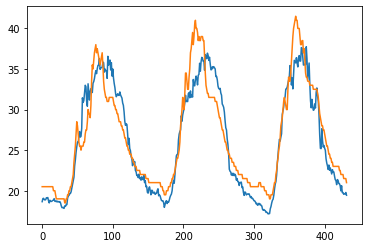

In [7]:
Y_test.index = range(len(Y_pred))
plt.plot(Y_pred)
plt.plot(Y_test['Y18'])
print(((Y_pred - np.array(Y_test['Y18']))**2).sum())

In [0]:
train_dt_j = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/AI_Friends_Season_1_Temperature_Fill_Data_weightmean_Original.csv').set_index('index')

Y_train = train_dt_j['Y18'][:4320]

In [0]:
# 승준
Y_pred = predict_test(X_train, Y_train, X_test)

4178.9675569010315


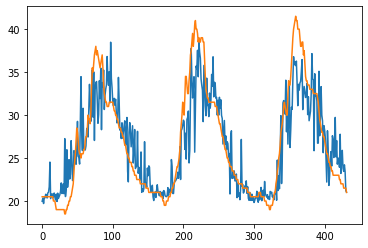

In [10]:
plt.plot(Y_pred)
plt.plot(Y_test['Y18'])
print(((Y_pred - np.array(Y_test['Y18']))**2).sum())

- 기온 삭제 00, 07, 28, 31, 32
- 현지 기압 01 삭제
- 풍속
- 해면 기압 삭제 05, 08, 09, 23, 33
- 누적 강수량 삭제 04, 06, 09

In [84]:
train_dt_j['Y18']

index
0       25.128487
1       27.687014
2       26.505215
3       23.254852
4       21.510336
          ...    
4747    21.500000
4748    21.500000
4749    21.500000
4750    21.500000
4751    21.000000
Name: Y18, Length: 4752, dtype: float64

In [0]:
train_dt['X00'] = train_dt[['X00','X07','X28','X31','X32']].mean(axis = 1)
train_dt.drop(['X07','X28','X31','X32','X01','X05','X08','X09','X23','X33','X04','X06','X09'], axis = 1, inplace = True)

In [0]:
X_train = train_dt.iloc[:4320, :28]
X_test = train_dt.iloc[4320:, :28]
Y_train = train_dt.loc[:4319, ['Y09', 'Y12']].mean(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

In [0]:
# mse / 9,12 평균
Y_pred = predict_test(X_train, Y_train, X_test)

2393.0077111725004


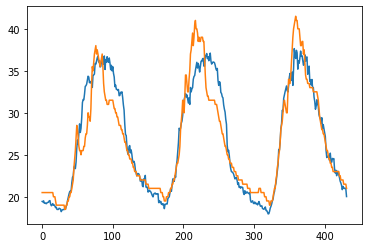

In [43]:
Y_test.index = range(len(Y_pred))
Y_pred = Y_pred - 0.5
plt.plot(Y_pred)
plt.plot(Y_test['Y18'])
print(((Y_pred - np.array(Y_test['Y18']))**2).sum())

In [103]:
# 4300개의 예측값(12,16 평균) + Y_의 실제값
before = train_dt[['Y12','Y16']].iloc[:-432].mean(axis = 1)
# after = main[[18]].mean(axis = 1)
after = train_dt.iloc[4320:,-1]

Y_train = pd.concat([before, after],ignore_index=True)

Y_train.head()

0    8.50
1    8.00
2    7.75
3    7.75
4    7.50
dtype: float64

In [104]:
X_train = train_dt.iloc[:, :28]
X_train.head()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7


In [0]:
def data_processing(X_data):
  X_data['X01'] = X_data[['X01','X06']].mean(axis = 1)
  X_data['X22'] = X_data[['X22','X29']].mean(axis = 1)
  X_data['X05'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
  X_data['X11'] = X_data[['X11','X34']].mean(axis = 1)
  # 13 삭제 / 14,16,19 0 값 삭제
  X_data = X_data.drop(['X06','X29','X08','X09','X23','X33','X34','X13','X14','X16','X19'], axis = 1)
  return X_data

In [108]:
test_dt.head()

,X00,X02,X03,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X24,X25,X26,X27,X29,X30,X34,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4752,19.94,1.5,1.3,0.0,0.0,96.1,333.6,0.0,199.6,0.0,36.0,1.1,0.0,94.7,0.0,1000.3,0.0,0.0,0.1,1006.0,999.5,91.4,0.0,194.7,0.0,84.0,59.9,0.0
4753,19.92,1.1,1.2,0.0,0.0,96.2,335.5,0.0,194.0,0.0,127.7,0.6,0.0,95.3,0.0,1000.2,0.0,0.0,0.3,1005.9,999.4,91.6,0.0,173.1,0.0,84.0,60.5,0.0
4754,19.90,1.3,1.2,0.0,0.0,96.4,0.0,0.0,172.9,0.0,59.0,0.0,0.0,93.9,0.0,1000.1,0.0,0.0,0.7,1005.9,999.3,92.0,0.0,208.6,0.0,85.0,60.8,0.0
4755,19.72,2.3,0.8,0.0,0.0,96.5,252.9,0.0,153.5,0.0,54.9,0.4,0.0,94.4,0.0,1000.1,0.0,0.0,0.6,1005.8,999.3,93.0,0.0,185.0,0.0,85.8,61.2,0.0
4756,19.68,1.1,0.7,0.0,0.0,96.6,238.2,0.0,173.8,0.0,48.8,0.8,0.0,95.7,0.0,1000.2,0.0,0.0,0.7,1005.9,999.2,92.3,0.0,162.8,0.0,87.3,61.7,0.0


In [0]:
Y_pred = predict_test(X_train, Y_train, test_dt)

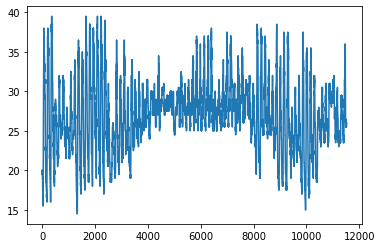

In [75]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')

In [0]:
X_train = train_dt.iloc[:,:-19]

In [0]:
Y_train = train_dt_j['Y18']

In [0]:
X_test = test_dt

In [0]:
Y_pred = predict_test(X_train, Y_train, X_test)

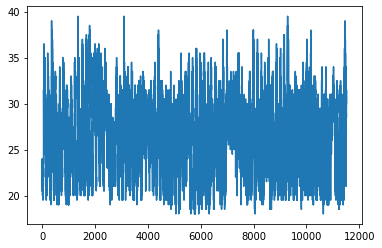

In [97]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')

In [113]:
X_train = train_dt.iloc[:,:-19]
X_train = data_processing(X_train)

X_train.head()

,X00,X01,X02,X03,X04,X05,X07,X10,X11,X12,X15,X17,X18,X20,X21,X22,X24,X25,X26,X27,X28,X30,X31,X32,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,989.20,1.2,0.6,0.0,1009.78,12.2,0.0,0.0,82.4,101.1,56.1,0.3,91.0,0.0,1002.05,1.1,2.3,0.5,1008.7,12.3,69.1,8.2,10.7,256.4,0.0,77.2,62.6,0.0
1,9.3,989.25,1.7,1.9,0.0,1009.84,12.1,0.0,0.0,81.2,165.3,0.0,0.4,91.9,0.0,1002.10,0.0,0.0,0.0,1008.7,12.1,70.3,8.3,10.3,215.4,0.0,77.3,63.5,0.0
2,9.4,989.35,1.1,2.3,0.0,1009.84,12.1,0.0,0.0,86.1,144.0,0.0,0.6,93.3,0.0,1002.00,0.0,0.0,0.0,1008.6,12.1,71.5,8.0,9.7,235.2,0.0,77.3,63.9,0.0
3,9.4,989.25,1.5,0.7,0.0,1009.80,12.0,0.0,0.0,87.7,115.9,294.1,0.1,93.4,0.0,1001.95,0.0,0.0,0.2,1008.7,12.1,73.2,7.7,9.4,214.0,0.0,77.5,64.5,0.0
4,9.2,989.30,0.8,1.7,0.0,1009.82,12.0,0.0,0.0,88.9,124.7,0.0,0.0,94.1,0.0,1001.95,0.0,0.0,0.0,1008.7,12.0,74.3,7.4,9.4,174.9,0.0,78.0,65.0,0.0


In [114]:
# 4300개의 예측값(12,16 평균) + Y_의 실제값
before = train_dt[['Y12','Y16']].iloc[:-432].mean(axis = 1)
# after = main[[18]].mean(axis = 1)
after = train_dt.iloc[4320:,-1]

Y_train = pd.concat([before, after],ignore_index=True)

Y_train.head()

0    8.50
1    8.00
2    7.75
3    7.75
4    7.50
dtype: float64

In [117]:
X_test = data_processing(test_dt)
X_test.head()

,X00,X01,X02,X03,X04,X05,X07,X10,X11,X12,X15,X17,X18,X20,X21,X22,X24,X25,X26,X27,X28,X30,X31,X32,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4752,18.7,987.55,1.5,1.3,0.0,1007.34,21.1,0.0,0.0,96.1,199.6,36.0,1.1,94.7,0.0,999.9,0.0,0.0,0.1,1006.0,23.2,91.4,17.5,19.2,194.7,0.0,84.0,59.9,0.0
4753,18.8,987.55,1.1,1.2,0.0,1007.28,21.2,0.0,0.0,96.2,194.0,127.7,0.6,95.3,0.0,999.8,0.0,0.0,0.3,1005.9,23.1,91.6,17.4,19.1,173.1,0.0,84.0,60.5,0.0
4754,19.0,987.50,1.3,1.2,0.0,1007.22,21.2,0.0,0.0,96.4,172.9,59.0,0.0,93.9,0.0,999.7,0.0,0.0,0.7,1005.9,23.1,92.0,17.2,19.0,208.6,0.0,85.0,60.8,0.0
4755,18.7,987.50,2.3,0.8,0.0,1007.20,21.1,0.0,0.0,96.5,153.5,54.9,0.4,94.4,0.0,999.7,0.0,0.0,0.6,1005.8,22.8,93.0,17.2,18.8,185.0,0.0,85.8,61.2,0.0
4756,18.4,987.55,1.1,0.7,0.0,1007.24,20.9,0.0,0.0,96.6,173.8,48.8,0.8,95.7,0.0,999.7,0.0,0.0,0.7,1005.9,22.8,92.3,17.4,18.9,162.8,0.0,87.3,61.7,0.0


In [0]:
Y_pred = predict_test(X_train, Y_train, X_test)

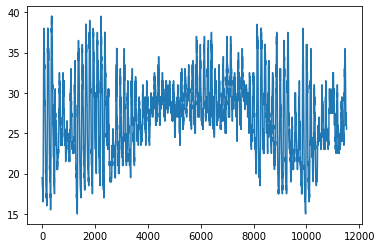

In [120]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')